Modified and verified by **Heejoon Moon**
- version: 11.28

## **0. Preprocessing Data**
- concat RGB frames and opticalflow
- transform videos to '.npy' format
  - '.npy' has 5 channels -> RGB (3) and opticalflow ((u, v) -> 2)
  - you can use another opticalflow algorithms

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

def getOpticalFlow(video):
    """Calculate dense optical flow of input video
    Args:
        video: the input video with shape of [frames,height,width,channel]. dtype=np.array
    Returns:
        flows_x: the optical flow at x-axis, with the shape of [frames,height,width,channel]
        flows_y: the optical flow at y-axis, with the shape of [frames,height,width,channel]
    """
    # initialize the list of optical flows
    gray_video = []
    for i in range(len(video)):
        img = cv2.cvtColor(video[i], cv2.COLOR_RGB2GRAY)
        gray_video.append(np.reshape(img, (224, 224, 1)))

    flows = []
    for i in range(0, len(video) - 1):
        # calculate optical flow between each pair of frames
        flow = cv2.calcOpticalFlowFarneback(gray_video[i], gray_video[i + 1], None, 0.5, 3, 15, 3, 5, 1.2,
                                            cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        # subtract the mean in order to eliminate the movement of camera
        flow[..., 0] -= np.mean(flow[..., 0])
        flow[..., 1] -= np.mean(flow[..., 1])
        # normalize each component in optical flow
        flow[..., 0] = cv2.normalize(flow[..., 0], None, 0, 255, cv2.NORM_MINMAX)
        flow[..., 1] = cv2.normalize(flow[..., 1], None, 0, 255, cv2.NORM_MINMAX)
        # Add into list
        flows.append(flow)

    # Padding the last frame as empty array
    flows.append(np.zeros((224, 224, 2)))

    return np.array(flows, dtype=np.float32)


def farneback_visual(flows, file_path):
    # visualization farneback optical flow map
    # save the map as 'farneback_optical_flow.mp4'
    h, w = flows.shape[1:3]

    path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/AnomalyDetection/optical_flows'
    file_name = '/'.join(file_path.split('.')[0].split('/')[-3:]) + '_opticalFlow'

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out_video = cv2.VideoWriter(os.path.join(path, file_name+'.mp4'), fourcc, 30.0, (int(w), int(h)), isColor=True)

    hsv = np.zeros((h, w, 3))
    hsv[..., 1] = 255
    for flow in flows:
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        hsv = np.float32(hsv)
        rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
        out_video.write(np.uint8(rgb))
    out_video.release()
    return None
    pass


def Video2Npy(file_path, resize=(224,224)):
    """Load video and tansfer it into .npy format
    Args:
        file_path: the path of video file
        resize: the target resolution of output video
    Returns:
        frames: gray-scale video
        flows: magnitude video of optical flows
    """
    # Load video
    cap = cv2.VideoCapture(file_path)
    # Get number of frames
    len_frames = int(cap.get(7))
    # Extract frames from video
    try:
        frames = []
        for i in range(len_frames-1):
            _, frame = cap.read()
            frame = cv2.resize(frame,resize, interpolation=cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = np.reshape(frame, (224,224,3))
            frames.append(frame)
    except:
        print("Error: ", file_path, len_frames,i)
    finally:
        frames = np.array(frames)
        cap.release()

    # Get the optical flow of video
    flows = getOpticalFlow(frames)

    # Visualize optical flow map
    optical_flow_map = farneback_visual(flows, file_path)

    result = np.zeros((len(flows),224,224,5))
    result[...,:3] = frames
    result[...,3:] = flows

    return result


def Save2Npy(file_dir, save_dir):   # modify this code to save the npy files for your directory or path
    """Transfer all the videos and save them into specified directory
    Args:
        file_dir: source folder of target videos
        save_dir: destination folder of output .npy files
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # List the files
    videos = os.listdir(file_dir)
    for v in tqdm(videos):
        # Split video name
        video_name = v.split('.')[0]
        # Get src
        video_path = os.path.join(file_dir, v)
        # Get dest
        save_path = os.path.join(save_dir, video_name+'.npy')
        # Load and preprocess video
        data = Video2Npy(file_path=video_path, resize=(224,224))
        data = np.uint8(data)
        # Save as .npy file
        np.save(save_path, data)

    return None

### convert data and save it (offline)

In [ ]:
source_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/AnomalyDetection/raw_video'
target_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/AnomalyDetection/npy_video'

for f1 in ['train', 'val']:
    for f2 in ['Fight', 'NonFight']:
        path1 = os.path.join(source_path, f1, f2)
        path2 = os.path.join(target_path, f1, f2)
        Save2Npy(file_dir=path1, save_dir=path2)

100%|██████████| 20/20 [02:02<00:00,  6.11s/it]


## **1. Build Data Loader**

In [3]:
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import cv2

class DataGenerator(Dataset):

    ### basic function templates for Dataset class in Pytorch : __init__, __len__, __getitem__###
    def __init__(self, directory, data_augmentation=True, phase='train'):
        self.phase=phase
        self.directory = directory
        self.data_aug = data_augmentation
        self.X_path, self.Y_dict = self.search_data()
        self.print_stats()

    def __len__(self):
        steps_per_epoch = int(len(self.X_path))
        return steps_per_epoch

    # get data and label corresponding to index using 'data_generation function'
    def __getitem__(self, index):
        data, label = self.data_generation(self.X_path[index])
        return data.float(), label

    #############################################################
    # -----------------codes down from this line are provided.------------------- #
    # call raw data using data path, and data processing including 'uniform sampling', 'color jittering', 'random flip', and 'normalize'
    #############################################################

    def load_data(self, path):
        data = np.load(path, mmap_mode='r') # Read the raw data from path
        data = self.uniform_sampling(data, target_frames=64) # Randomly sample number of target frames
        if self.data_aug: # If data is augmented...
            data[..., :3] = self.color_jitter(data[..., :3])
            data = self.random_flip(data, prob=0.5) # Random flip image into random direction
        data[..., :3] = self.normalize(data[..., :3]) # Normalize RGB
        data[..., 3:] = self.normalize(data[..., 3:]) # Normalize optical flows
        return data

    # shuffle data
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    # Normalize data
    def normalize(self, data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std

    def random_flip(self, video, prob):
        s = np.random.rand()
        if s < prob:
            video = np.flip(video, (2,)) # Flip in width direction
        return video

    def uniform_sampling(self, video, target_frames=64):
        # get total frames of input video and calculate sampling interval
        len_frames = int(len(video))
        interval = int(np.ceil(len_frames/target_frames))
        # init empty list for sampled video and
        sampled_video = []
        for i in range(0,len_frames,interval):
            sampled_video.append(video[i])
        # calculate numer of padded frames and fix it
        num_pad = target_frames - len(sampled_video) # num pad = # target frame - # current frame
        padding = []
        if num_pad>0:
            for i in range(-num_pad,0):
                try:
                    padding.append(video[i]) # Fill with the last video frame
                except:
                    padding.append(video[0])
            sampled_video += padding # Add padding results
        # get sampled video
        return np.array(sampled_video, dtype=np.float32)

    # Jitter = spread values
    def color_jitter(self, video):
        s_jitter = np.random.uniform(-0.2, 0.2)
        v_jitter = np.random.uniform(-30, 30)
        for i in range(len(video)):
            hsv = cv2.cvtColor(np.array(video[i]), cv2.COLOR_RGB2HSV) # Convert RGB -> HSV
            s = hsv[..., 1] + s_jitter # saturation jitter
            v = hsv[..., 2] + v_jitter # Value jitter
            # Flip
            s[s < 0] = 0
            s[s > 1] = 1
            v[v < 0] = 0
            v[v > 255] = 255
            hsv[..., 1] = s # set jittered saturation
            hsv[..., 2] = v # Set jittered value
            video[i] = torch.Tensor(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)) # Convert HSV -> RGB again
        return video

    # print current state sof the Dataset class
    def print_stats(self):
            self.n_files = len(self.X_path)
            self.n_classes = len(self.dirs)
            self.indexes = np.arange(len(self.X_path))
            np.random.shuffle(self.indexes)
            print("Found {} files belonging to {} classes.".format(self.n_files, self.n_classes))
            for i, label in enumerate(self.dirs):
                print('{:10s} : {}'.format(label, i))

    #############################################################
    # Fill the missing part of the code with functions given above
    #############################################################

    # get data and label(one-hot encoded) from path list/dictionary
    def search_data(self):
        X_path = []
        Y_dict = {}
        self.dirs = sorted(os.listdir(self.directory)) # Get sorted file directories
        #one_hots = [0.0, 0.0]
        for i, folder in enumerate(self.dirs):
            folder_path = os.path.join(self.directory, folder)  # folder_path = ...train/Fight or ...train/NonFight
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                # Add file path into X_path
                X_path.append(file_path)
                # Assign one hot encoded vector into Y_dict
                Y_dict[file_path] = i
        return X_path, Y_dict

    # define batch x using 'load_data' function and batch_y from self.Y_dict.
    def data_generation(self, batch_path):
        #batch_x = np.array(###Fill here###)
        batch_x = np.array(self.load_data(batch_path))
        #batch_y = np.array(###Fill here###)
        batch_y = np.array(self.Y_dict[batch_path])

        # Transfer numpy array to tensor
        ###Fill here###
        batch_x = torch.tensor(batch_x)
        batch_y = torch.tensor(batch_y)

        return batch_x, batch_y

## **2. Build Simple Model**
- this model is 'Flow Gated Network' proposed in 'RWF2000'
- you can use off-the-shelf architectures such as ResNet, EfficientNet, etc.
- model structure is produced in below image
- Fully-Connected layer is little bit different with image, so we provide Fully-Connected layer structure

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        self.relu=nn.ReLU()    # inplace=True 삭제, error 뜸
        ### optical layer에 sigmoid 함수 필요해서 추가함 + fusion and pooling 단계 maxpool3d도
        self.sigmoid = nn.Sigmoid()
        self.maxpool = nn.MaxPool3d(kernel_size=(8, 1 ,1), stride=(8, 1, 1))

        ## Hint: Please refer to above table for constructing layers
        # Construct block of RGB layers which takes RGB channel(3) as input
        self.rgb_conv1 = nn.Conv3d(3, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.rgb_conv2 = nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.rgb_maxpool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.rgb_conv3 = nn.Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.rgb_conv4 = nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.rgb_maxpool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.rgb_conv5 = nn.Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.rgb_conv6 = nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.rgb_maxpool3 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.rgb_conv7 = nn.Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.rgb_conv8 = nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.rgb_maxpool4 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        # Construct block of optical flow layers which takes the optical flow channel(2) as input
        self.opt_conv1 = nn.Conv3d(2, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.opt_conv2 = nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.opt_maxpool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.opt_conv3 = nn.Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.opt_conv4 = nn.Conv3d(16, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.opt_maxpool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.opt_conv5 = nn.Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.opt_conv6 = nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.opt_maxpool3 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.opt_conv7 = nn.Conv3d(32, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.opt_conv8 = nn.Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.opt_maxpool4 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        # Construct merging Block
        self.merge_conv1 = nn.Conv3d(32, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.merge_conv2 = nn.Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.merge_maxpool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.merge_conv3 = nn.Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.merge_conv4 = nn.Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.merge_maxpool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.merge_conv5 = nn.Conv3d(64, 128, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
        self.merge_conv6 = nn.Conv3d(128, 128, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
        self.merge_maxpool3 = nn.MaxPool3d(kernel_size=(2, 3, 3), stride=(2, 3, 3))

        ## 얘는 주어진 코드
        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 2)

        # Initialize weights
        self.__init_weight()

    def forward(self, x):
        x = x.transpose(2, 4)
        x = x.transpose(3, 4)
        x = x.transpose(1, 2)
        rgb = x[:,:3,:,:,:]
        opt = x[:,3:5,:,:,:]

        # Pass through the RGB data through the blocks of RGB layers
        rgb = self.rgb_conv1(rgb)
        rgb = self.relu(rgb)
        rgb = self.rgb_conv2(rgb)
        rgb = self.relu(rgb)
        rgb = self.rgb_maxpool1(rgb)
        rgb = self.rgb_conv3(rgb)
        rgb = self.relu(rgb)
        rgb = self.rgb_conv4(rgb)
        rgb = self.relu(rgb)
        rgb = self.rgb_maxpool2(rgb)

        rgb = self.rgb_conv5(rgb)
        rgb = self.relu(rgb)
        rgb = self.rgb_conv6(rgb)
        rgb = self.relu(rgb)
        rgb = self.rgb_maxpool3(rgb)
        rgb = self.rgb_conv7(rgb)
        rgb = self.relu(rgb)
        rgb = self.rgb_conv8(rgb)
        rgb = self.relu(rgb)
        rgb = self.rgb_maxpool4(rgb)

        # Pass through the optical flow data through the blocks of RGB layers
        opt = self.opt_conv1(opt)
        opt = self.relu(opt)
        opt = self.opt_conv2(opt)
        opt = self.relu(opt)
        opt = self.opt_maxpool1(opt)
        opt = self.opt_conv3(opt)
        opt = self.relu(opt)
        opt = self.opt_conv4(opt)
        opt = self.relu(opt)
        opt = self.opt_maxpool2(opt)

        opt = self.opt_conv5(opt)
        opt = self.relu(opt)
        opt = self.opt_conv6(opt)
        opt = self.relu(opt)
        opt = self.opt_maxpool3(opt)
        opt = self.opt_conv7(opt)
        opt = self.sigmoid(opt)
        opt = self.opt_conv8(opt)
        opt = self.sigmoid(opt)
        opt = self.opt_maxpool4(opt)

        # Fuse by performing elementwise multiplication of rgb and opt tensors.
        #fused = ## fill here ##
        fused = rgb * opt
        # Perform maxpooling of fused
        #fused = ## fill here ##
        fused = self.maxpool(fused)

        # Pass through the fused data into merging block
        merged = self.merge_conv1(fused)
        merged = self.relu(merged)
        merged = self.merge_conv2(merged)
        merged = self.relu(merged)
        merged = self.merge_maxpool1(merged)
        merged = self.merge_conv3(merged)
        merged = self.relu(merged)
        merged = self.merge_conv4(merged)
        merged = self.relu(merged)
        merged = self.merge_maxpool2(merged)
        merged = self.merge_conv5(merged)
        merged = self.relu(merged)
        merged = self.merge_conv6(merged)
        merged = self.relu(merged)
        merged = self.merge_maxpool3(merged)

        # Fully Connected Layers
        x = merged.view(merged.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                # Perform weight initialization ("kaiming normal")
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    #nn.init.constant_(m.bias, 0)
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / torch.sqrt(torch.tensor(fan_in))
                    nn.init.uniform_(m.bias, -bound, bound)

## **3. Training the Model**
- set hyper-parameters for training

In [5]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00


In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm
import wandb


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define model, optimizer and criterion
model = FusionModel().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6, nesterov=True)
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)
loss_fn = nn.CrossEntropyLoss()

trainset_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/AnomalyDetection/npy_video/train'
validation_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/AnomalyDetection/npy_video/val'

# define dataset and dataloader
train_dataset = DataGenerator(trainset_path, data_augmentation=True, phase='train')
val_dataset = DataGenerator(validation_path, data_augmentation=True, phase='val')
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

# epoch = 30
epochs = 30
# learning rate = 0.003

# optimizer = SGD
# weight decay = 1e-6
# momentum = 0.9
# nesterov = True
# gamma = 0.7

# loss = CrossEntropy

# assign device cpu or gpu
min_loss = np.inf


Found 160 files belonging to 2 classes.
Fight      : 0
NonFight   : 1
Found 40 files belonging to 2 classes.
Fight      : 0
NonFight   : 1


In [7]:
from tqdm.auto import tqdm as tqdm1
import torch.nn.functional as F
def train():
    model.train()
    acc_temp = 0
    running_loss = 0.0

    # forward propagation and backpropagation
    # calculate accuracy and loss on training set
    for inputs, targets in tqdm1(train_loader, desc='Training'):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        acc_temp += (predicted == targets).sum().item()
        running_loss += loss.item()

    train_acc = acc_temp / len(train_loader.dataset)
    train_loss = running_loss / len(train_loader.dataset)

    return train_acc, train_loss

In [8]:
def val():
    model.eval()
    with torch.no_grad():
        running_loss_val = 0
        acc_temp_val =0

        # calculate accuracy and loss on validation set
        for inputs, targets in tqdm1(val_loader, desc='Validation'):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            _, predicted = torch.max(outputs, 1)
            acc_temp_val += (predicted == targets).sum().item()
            running_loss_val += loss.item()

        val_acc = acc_temp_val / len(val_loader.dataset)
        val_loss = running_loss_val / len(val_loader.dataset)

    return val_acc, val_loss

In [9]:
import random
import numpy as np

seed=0
random.seed(seed)
np.random.seed(seed)
device='cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)
if device =='cuda':
    print('gpu device is using')
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

wandb.login()
wandb.init(project='computer vision', name='RWF2000')

for epoch in tqdm(range(epochs)):
    # Perform training and validation
    # Save the weights
    # Log the training and validation results
    epoch_acc, epoch_loss = train()
    epoch_acc_val, epoch_loss_val = val()

    print(f'Epoch: {epoch}, Train Accuracy: {epoch_acc}, Train Loss: {epoch_loss}')
    print(f'Epoch: {epoch}, Valid Accuracy: {epoch_acc_val}, Valid Loss: {epoch_loss_val}')
    wandb.log({'Epoch':epoch, 'Train Accuracy':epoch_acc, "Train Loss":epoch_loss})
    wandb.log({'Epoch':epoch, 'Valid Accuracy':epoch_acc_val, "Valid Loss":epoch_loss_val})

    if epoch_loss_val <= min_loss:
        min_loss = epoch_loss_val
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Computer Vision/AnomalyDetection/model_weight.pth')

gpu device is using


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ryusejong324. Use `wandb login --relogin` to force relogin


  0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

  3%|▎         | 1/30 [08:14<3:59:01, 494.53s/it]

Epoch: 0, Train Accuracy: 0.43125, Train Loss: 0.17587384805083275
Epoch: 0, Valid Accuracy: 0.5, Valid Loss: 0.1732683226466179


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

  7%|▋         | 2/30 [10:53<2:18:33, 296.92s/it]

Epoch: 1, Train Accuracy: 0.4625, Train Loss: 0.17422932609915734
Epoch: 1, Valid Accuracy: 0.5, Valid Loss: 0.17294351309537886


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 3/30 [13:31<1:45:12, 233.78s/it]

Epoch: 2, Train Accuracy: 0.49375, Train Loss: 0.17357450872659683
Epoch: 2, Valid Accuracy: 0.5, Valid Loss: 0.17198263108730316


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [16:11<1:28:33, 204.36s/it]

Epoch: 3, Train Accuracy: 0.44375, Train Loss: 0.17484403550624847
Epoch: 3, Valid Accuracy: 0.5, Valid Loss: 0.17218435555696487


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [18:50<1:18:27, 188.29s/it]

Epoch: 4, Train Accuracy: 0.5625, Train Loss: 0.1724543035030365
Epoch: 4, Valid Accuracy: 0.625, Valid Loss: 0.17041646540164948


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 6/30 [21:30<1:11:27, 178.66s/it]

Epoch: 5, Train Accuracy: 0.5125, Train Loss: 0.17177799418568612
Epoch: 5, Valid Accuracy: 0.5, Valid Loss: 0.17217601984739303


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 23%|██▎       | 7/30 [24:10<1:06:10, 172.62s/it]

Epoch: 6, Train Accuracy: 0.525, Train Loss: 0.17326916046440602
Epoch: 6, Valid Accuracy: 0.5, Valid Loss: 0.17148467153310776


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 27%|██▋       | 8/30 [26:50<1:01:42, 168.31s/it]

Epoch: 7, Train Accuracy: 0.56875, Train Loss: 0.1739512026309967
Epoch: 7, Valid Accuracy: 0.5, Valid Loss: 0.17109671831130982


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 9/30 [29:28<57:51, 165.31s/it]  

Epoch: 8, Train Accuracy: 0.575, Train Loss: 0.17165150102227927
Epoch: 8, Valid Accuracy: 0.5, Valid Loss: 0.1693926513195038


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 33%|███▎      | 10/30 [32:08<54:30, 163.53s/it]

Epoch: 9, Train Accuracy: 0.64375, Train Loss: 0.16824623718857765
Epoch: 9, Valid Accuracy: 0.85, Valid Loss: 0.15983595550060273


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 37%|███▋      | 11/30 [34:47<51:21, 162.19s/it]

Epoch: 10, Train Accuracy: 0.54375, Train Loss: 0.17387770656496288
Epoch: 10, Valid Accuracy: 0.5, Valid Loss: 0.17361074537038804


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 12/30 [37:28<48:30, 161.70s/it]

Epoch: 11, Train Accuracy: 0.475, Train Loss: 0.1742099892348051
Epoch: 11, Valid Accuracy: 0.5, Valid Loss: 0.17312610000371934


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 43%|████▎     | 13/30 [40:07<45:39, 161.16s/it]

Epoch: 12, Train Accuracy: 0.5, Train Loss: 0.17388457618653774
Epoch: 12, Valid Accuracy: 0.5, Valid Loss: 0.17213796228170394


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 47%|████▋     | 14/30 [42:47<42:52, 160.76s/it]

Epoch: 13, Train Accuracy: 0.54375, Train Loss: 0.1716993536800146
Epoch: 13, Valid Accuracy: 0.65, Valid Loss: 0.16633435487747192


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 15/30 [45:26<40:04, 160.27s/it]

Epoch: 14, Train Accuracy: 0.65625, Train Loss: 0.1585488410666585
Epoch: 14, Valid Accuracy: 0.725, Valid Loss: 0.13465722426772117


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 53%|█████▎    | 16/30 [48:06<37:21, 160.09s/it]

Epoch: 15, Train Accuracy: 0.51875, Train Loss: 0.17370331156998872
Epoch: 15, Valid Accuracy: 0.5, Valid Loss: 0.17375196367502213


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 57%|█████▋    | 17/30 [50:45<34:37, 159.84s/it]

Epoch: 16, Train Accuracy: 0.45625, Train Loss: 0.17396153546869755
Epoch: 16, Valid Accuracy: 0.5, Valid Loss: 0.17329050451517106


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 18/30 [53:25<31:58, 159.85s/it]

Epoch: 17, Train Accuracy: 0.43125, Train Loss: 0.17554990947246552
Epoch: 17, Valid Accuracy: 0.5, Valid Loss: 0.1732917383313179


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 63%|██████▎   | 19/30 [56:05<29:18, 159.86s/it]

Epoch: 18, Train Accuracy: 0.4375, Train Loss: 0.17387819699943066
Epoch: 18, Valid Accuracy: 0.5, Valid Loss: 0.17335609197616578


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 67%|██████▋   | 20/30 [58:43<26:33, 159.31s/it]

Epoch: 19, Train Accuracy: 0.45, Train Loss: 0.17477732263505458
Epoch: 19, Valid Accuracy: 0.5, Valid Loss: 0.17328474968671798


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 70%|███████   | 21/30 [1:01:20<23:47, 158.64s/it]

Epoch: 20, Train Accuracy: 0.475, Train Loss: 0.17480666190385818
Epoch: 20, Valid Accuracy: 0.5, Valid Loss: 0.17361631393432617


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 73%|███████▎  | 22/30 [1:03:58<21:07, 158.45s/it]

Epoch: 21, Train Accuracy: 0.475, Train Loss: 0.174276065453887
Epoch: 21, Valid Accuracy: 0.5, Valid Loss: 0.1732824608683586


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 77%|███████▋  | 23/30 [1:06:37<18:29, 158.46s/it]

Epoch: 22, Train Accuracy: 0.4875, Train Loss: 0.17410161942243577
Epoch: 22, Valid Accuracy: 0.5, Valid Loss: 0.1732872247695923


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 24/30 [1:09:16<15:51, 158.63s/it]

Epoch: 23, Train Accuracy: 0.4875, Train Loss: 0.17433587051928043
Epoch: 23, Valid Accuracy: 0.5, Valid Loss: 0.1734102338552475


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 83%|████████▎ | 25/30 [1:11:54<13:12, 158.60s/it]

Epoch: 24, Train Accuracy: 0.4625, Train Loss: 0.17423240803182125
Epoch: 24, Valid Accuracy: 0.5, Valid Loss: 0.1733846127986908


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 87%|████████▋ | 26/30 [1:14:31<10:32, 158.18s/it]

Epoch: 25, Train Accuracy: 0.46875, Train Loss: 0.17413363307714463
Epoch: 25, Valid Accuracy: 0.5, Valid Loss: 0.17328840047121047


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 90%|█████████ | 27/30 [1:17:11<07:55, 158.60s/it]

Epoch: 26, Train Accuracy: 0.48125, Train Loss: 0.17409119717776775
Epoch: 26, Valid Accuracy: 0.5, Valid Loss: 0.17333542108535765


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 93%|█████████▎| 28/30 [1:19:49<05:17, 158.52s/it]

Epoch: 27, Train Accuracy: 0.45, Train Loss: 0.17428749203681945
Epoch: 27, Valid Accuracy: 0.5, Valid Loss: 0.17329344600439073


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

 97%|█████████▋| 29/30 [1:22:29<02:38, 158.77s/it]

Epoch: 28, Train Accuracy: 0.4875, Train Loss: 0.1746072769165039
Epoch: 28, Valid Accuracy: 0.5, Valid Loss: 0.17331267893314362


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 30/30 [1:25:07<00:00, 170.25s/it]

Epoch: 29, Train Accuracy: 0.46875, Train Loss: 0.17400455474853516
Epoch: 29, Valid Accuracy: 0.5, Valid Loss: 0.17353825122117997


In [ ]:
source_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/AnomalyDetection/raw_video'
target_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/AnomalyDetection/npy_video'

for f1 in ['test']:
    for f2 in ['Fight', 'NonFight']:
        path1 = os.path.join(source_path, f1, f2)
        path2 = os.path.join(target_path, f1, f2)
        Save2Npy(file_dir=path1, save_dir=path2)

100%|██████████| 10/10 [01:18<00:00,  7.87s/it]


In [10]:
best_model = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/AnomalyDetection/model_weight.pth'
test_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/AnomalyDetection/npy_video/test'

test_dataset = DataGenerator(directory=test_path, data_augmentation=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)

Found 20 files belonging to 2 classes.
Fight      : 0
NonFight   : 1


Test: 100%|██████████| 20/20 [00:39<00:00,  2.00s/it]

test accuracy: 0.7
AUROC: 0.7000000000000001


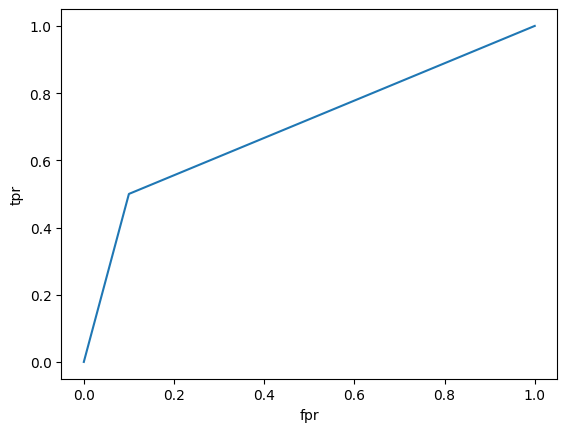

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model.load_state_dict(torch.load(best_model))
model.eval()
with torch.no_grad():
    # calculate accuracy and AUROC on test set
    # print accuracy
    # plot AUROC
    running_loss_test = 0
    acc_temp_test =0

    preds = []
    targets = []
    for input, target in tqdm(test_loader, desc='Test'):
        input, target = input.to(device), target.to(device)

        output = model(input)
        loss = loss_fn(output, target)

        _, predicted = torch.max(output, 1)
        acc_temp_test += (predicted == target).sum().item()
        running_loss_test += loss.item()

        preds.append(predicted.cpu().numpy())
        targets.append(target.cpu().numpy())

    test_acc = acc_temp_test / len(test_loader.dataset)
    test_loss = running_loss_test / len(test_loader.dataset)
    preds = np.array(preds).flatten()
    targets = np.array(targets).flatten()

print(f'test accuracy: {test_acc}')
print(f'AUROC: {roc_auc_score(targets, preds)}')

fpr, tpr, thresholds = roc_curve(targets, preds)
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()